# DL Study fifth week  
- VGG16 model 구축  
- VGG model은 ImageNet Challenge에서 2위를 차지한 모델  
- 이때 1위는 GoogLeNet이었으나 더 주목받은 모델은 VGG model이다  
- 매우 단순하며 CNN의 기본 아키텍쳐인 Convolution, Pooling, Fully Connected Layer만을 사용했다는 점에서 유명해진 모델이다  
- 이번 스터디 주 내용은 직접 VGG16 모델을 구축해보고 학습시키고, 사전 훈련된 tensorflow의 내장 VGG16 모델을 fine-tuning해서 학습시켜 성능을 비교해볼 것이다

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import(
    Sequential,
    Model
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
)
from tensorflow.keras.applications.vgg16 import VGG16

## dataset 불러오기

In [2]:
import os
import cv2
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [3]:
def load_file(files):
    # 빈 리스트 생성
    image_list = []
    for file in tqdm(files):
        # 이미지 불러오기
        img = cv2.imread(file)
        # BGR에서 RGB로 변환하기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # 224x224로 resize하기
        img = cv2.resize(img, (224,224))
        # 정규화와 함께 리스트에 추가
        image_list.append(img/255.)
    return np.array(image_list)

In [4]:
def create_data(path, subset):
    # 파일 불러오기
    cat_files = glob(path+subset+'_set/cats/*.jpg')
    dog_files = glob(path+subset+'_set/dogs/*.jpg')
    # 이미지 로드
    cat_images = load_file(cat_files)
    dog_images = load_file(dog_files)
    # 라벨 생성
    cat_labels = np.zeros(len(cat_images))
    dog_labels = np.ones(len(dog_images))
    # 데이터 합치기
    images = np.concatenate((cat_images, dog_images), axis=0)
    labels = np.concatenate((cat_labels, dog_labels), axis=0)
    # 데이터 섞기
    idx = np.arange(len(images))
    np.random.shuffle(idx)
    shuffled_image = images[idx]
    shuffled_label = labels[idx]
    
    return shuffled_image, shuffled_label

In [5]:
path = 'C:/Users/user/MY_DL/classification/dataset/catdog/'
train_images, train_labels = create_data(path, subset='train')
valid_images, valid_labels = create_data(path, subset='valid')
test_images, test_labels = create_data(path, subset='test')

  0%|          | 0/2389 [00:00<?, ?it/s]

  0%|          | 0/2535 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [6]:
print(train_images.shape, train_labels.shape)
print(valid_images.shape, valid_labels.shape)
print(test_images.shape, test_labels.shape)

(4924, 224, 224, 3) (4924,)
(872, 224, 224, 3) (872,)
(1460, 224, 224, 3) (1460,)


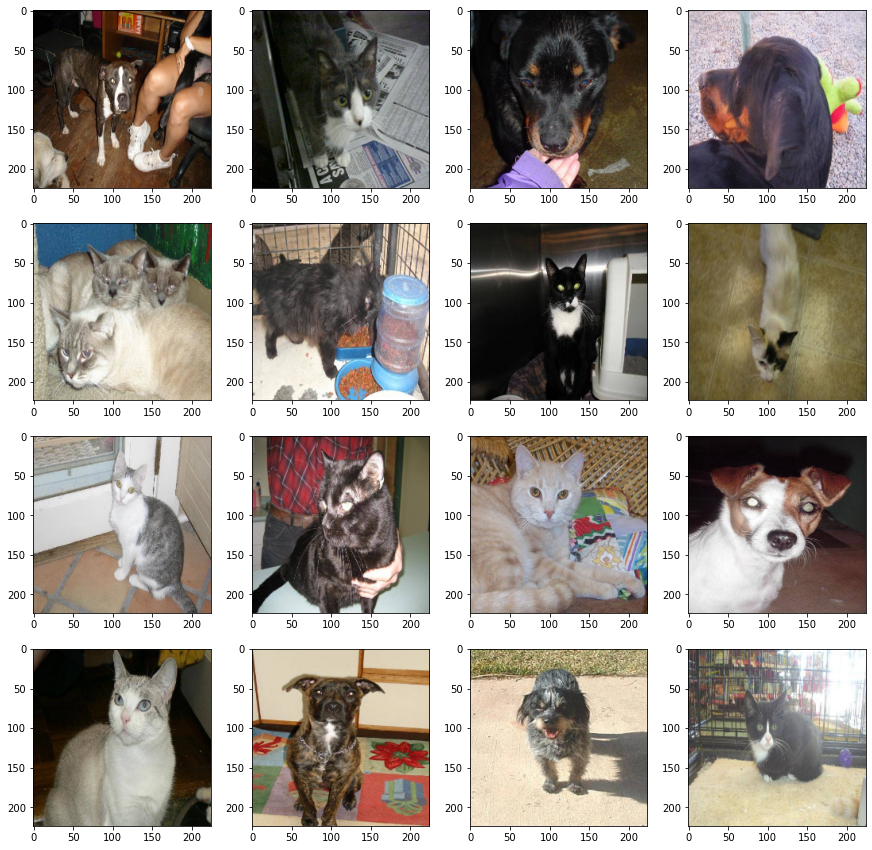

In [7]:
def show_images(nrow, ncol, dataset):
    plt.figure(figsize=(15,15))
    for i in range(nrow*ncol):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(dataset[i])
    plt.show()
    
show_images(4, 4, train_images)

## 직접 모델 만들기

In [8]:
# 논문의 vgg16 model 직접 구축
self_vgg16 = Sequential([
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu',
           input_shape=(224,224,3)),
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid'),
])

self_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [9]:
# vgg16 model을 fine-tuning 진행
self_vgg16_tuning = Sequential([
    Conv2D(16, (3,3), strides=1, padding='same', activation='relu',
           input_shape=(224,224,3)),
    Conv2D(16, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(32, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid'),
])

self_vgg16_tuning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [10]:
# 직접 만든 모델 학습시키기
lr = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=lr)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
self_vgg16_tuning.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
EPOCH = 100
history1 = self_vgg16_tuning.fit(train_images, train_labels,
                                 epochs=EPOCH,
                                 validation_data=(valid_images, valid_labels),
                                 shuffle=True,
                                 batch_size=32,
                                 callbacks=[earlystop])

Epoch 1/100
154/154 [==============================] - 12s 29ms/step - loss: 0.6920 - accuracy: 0.5126 - val_loss: 0.6775 - val_accuracy: 0.5757
Epoch 2/100
154/154 [==============================] - 4s 24ms/step - loss: 0.6527 - accuracy: 0.6076 - val_loss: 0.5395 - val_accuracy: 0.7695
Epoch 3/100
154/154 [==============================] - 4s 23ms/step - loss: 0.5923 - accuracy: 0.6810 - val_loss: 0.4144 - val_accuracy: 0.8394
Epoch 4/100
154/154 [==============================] - 4s 24ms/step - loss: 0.5573 - accuracy: 0.7173 - val_loss: 0.4722 - val_accuracy: 0.7649
Epoch 5/100
154/154 [==============================] - 4s 24ms/step - loss: 0.5250 - accuracy: 0.7362 - val_loss: 0.4242 - val_accuracy: 0.8154
Epoch 6/100
154/154 [==============================] - 4s 24ms/step - loss: 0.4942 - accuracy: 0.7553 - val_loss: 0.5559 - val_accuracy: 0.7190
Epoch 7/100
154/154 [==============================] - 4s 24ms/step - loss: 0.4586 - accuracy: 0.7813 - val_loss: 0.4227 - val_accuracy

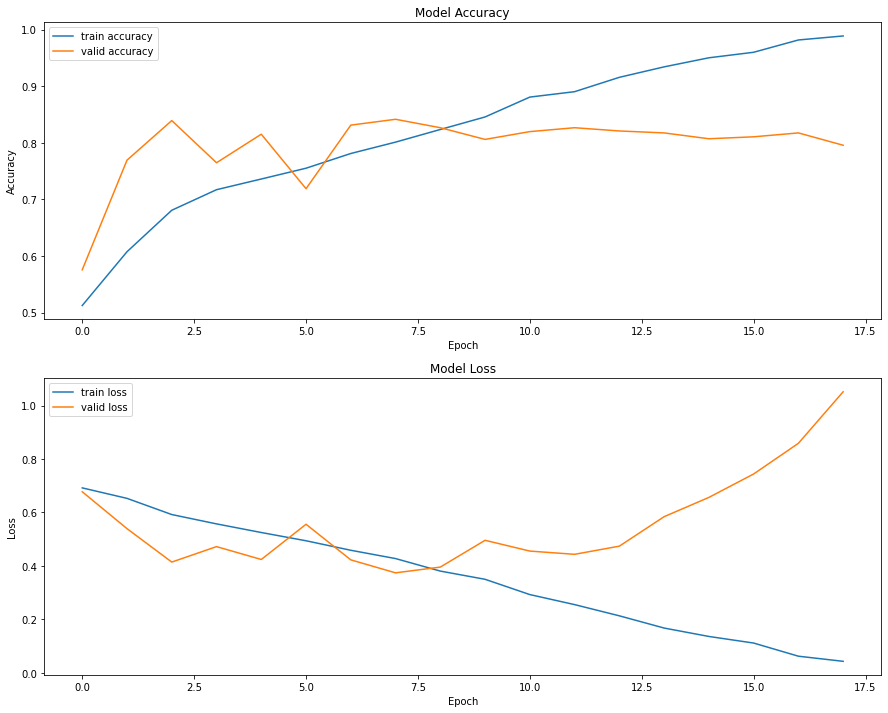

In [12]:
# check accuracy and loss
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(history1.history['accuracy'], label='train accuracy')
plt.plot(history1.history['val_accuracy'], label='valid accuracy')
#plt.ylim(0,1)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.subplot(2,1,2)
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='valid loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0,1)
plt.legend(loc='upper left')
plt.show()

In [13]:
# check model performance
test_loss, test_acc = self_vgg16.evaluate(test_images, test_labels)
print(f'Error: {test_loss}, Accuracy: {round(test_acc*100)}%')

46/46 [==============================] - 1s 11ms/step - loss: 1.1788 - accuracy: 0.7397
Error: 1.178791880607605, Accuracy: 74%


## tensorflow 내장 사전 훈련된 VGG16 모델 fine-tuning하기

In [14]:
# tensorflow 내장 VGG16 사용하기  
tf_vgg16 = VGG16(weights='imagenet')
tf_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# output layer의 노드 수를 2로 하기 위해 fine tuning 진행
last_layer = tf_vgg16.get_layer('fc2')
last_output = last_layer.output

x = Dense(1, activation='sigmoid')(last_output)

new_tf_vgg16 = Model(inputs=tf_vgg16.input, outputs=x)
new_tf_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 사전 훈련된 모델 학습시키기

In [16]:
# 직접 만든 모델 학습시키기
lr = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=lr)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
new_tf_vgg16.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
EPOCH = 100
history2 = new_tf_vgg16.fit(train_images, train_labels,
                            epochs=EPOCH,
                            validation_data=(valid_images, valid_labels),
                            shuffle=True,
                            batch_size=32,
                            callbacks=[earlystop])

Epoch 1/100
154/154 [==============================] - 26s 145ms/step - loss: 0.8000 - accuracy: 0.5349 - val_loss: 0.5295 - val_accuracy: 0.7523
Epoch 2/100
154/154 [==============================] - 19s 121ms/step - loss: 0.4747 - accuracy: 0.7734 - val_loss: 0.2895 - val_accuracy: 0.8647
Epoch 3/100
154/154 [==============================] - 19s 121ms/step - loss: 0.2732 - accuracy: 0.8844 - val_loss: 0.2613 - val_accuracy: 0.8922
Epoch 4/100
154/154 [==============================] - 19s 121ms/step - loss: 0.1344 - accuracy: 0.9456 - val_loss: 0.1459 - val_accuracy: 0.9427
Epoch 5/100
154/154 [==============================] - 19s 122ms/step - loss: 0.0970 - accuracy: 0.9630 - val_loss: 0.2056 - val_accuracy: 0.9346
Epoch 6/100
154/154 [==============================] - 19s 122ms/step - loss: 0.0777 - accuracy: 0.9716 - val_loss: 0.1488 - val_accuracy: 0.9461
Epoch 7/100
154/154 [==============================] - 19s 122ms/step - loss: 0.0446 - accuracy: 0.9833 - val_loss: 0.1901 -

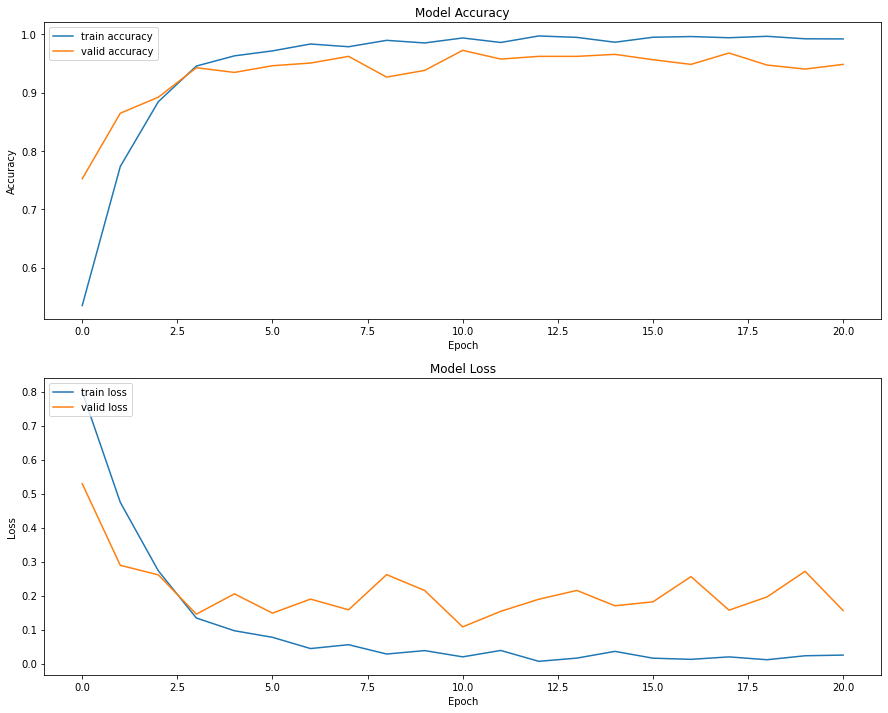

In [18]:
# check accuracy and loss
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'], label='train accuracy')
plt.plot(history2.history['val_accuracy'], label='valid accuracy')
#plt.ylim(0,1)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.subplot(2,1,2)
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='valid loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0,1)
plt.legend(loc='upper left')
plt.show()

In [19]:
# check model performance
test_loss, test_acc = new_tf_vgg16.evaluate(test_images, test_labels)
print(f'Error: {test_loss}, Accuracy: {round(test_acc*100)}%')

46/46 [==============================] - 3s 65ms/step - loss: 0.1529 - accuracy: 0.9418
Error: 0.15294037759304047, Accuracy: 94%
